In [10]:
pip install segyio

In [11]:
pip install lasio

In [13]:
import segyio
import pandas as pd
import numpy as np
import os
import lasio
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/2024_Geohackathon')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

 best_gb_perm_improved.pkl		 scaler.pkl
 best_gb_phie_improved.pkl		 seismic
 best_rf_phit_improved.pkl		'Unknown Well 1_final_predictions.csv'
 best_rf_temp_gradient_improved.pkl	'Unknown Well 2_final_predictions.csv'
 processed_well_logs.csv		'well logs'
 processed_well_logs_with_metadata.csv


In [22]:
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore

# Define the directory containing the LAS files
las_directory = "/content/drive/MyDrive/2024_Geohackathon/well logs"

# Initialize a dictionary to store DataFrames for each well
well_dataframes = {}

# Check if directory exists and is not empty
if not os.path.exists(las_directory) or len(os.listdir(las_directory)) == 0:
    raise FileNotFoundError(f"No files found in the directory: {las_directory}")

# List all files in the directory
file_list = os.listdir(las_directory)
print("Files in directory:", file_list)

# Iterate through the files
for filename in file_list:
    filepath = os.path.join(las_directory, filename)
    print(f"Processing file: {filename}")

    try:
        # Read the LAS file using lasio
        las = lasio.read(filepath)

        # Convert the LAS data to a pandas DataFrame
        df = las.df()
        df.reset_index(inplace=True)

        # Add a column for the well name
        well_name = filename.replace(".las", "")  # Remove extension for the well name
        df["Well Name"] = well_name

        # Ensure 'DEPT' is present and properly ordered
        if 'DEPT' in df.columns:
            df.sort_values(by='DEPT', inplace=True)
        else:
            raise ValueError(f"'DEPT' column missing in {filename}")

        # Align columns to match the DEPT column length
        for col in df.columns:
            if col != 'DEPT' and len(df[col]) != len(df['DEPT']):
                print(f"Aligning column '{col}' in {filename} to match DEPT length.")
                df[col] = df[col].reindex(df['DEPT'].index).fillna(np.nan)

        # Standardize column names
        standard_columns = [
            'DEPT', 'RHOB', 'VSHALE', 'NPHI', 'RDEEP', 'PHIE', 'PHIT',
            'PERM', 'TEMP_GRADIENT', 'SP', 'GR', 'AC'
        ]
        for col in standard_columns:
            if col not in df.columns:
                df[col] = np.nan

        # Handle duplicate depths
        df = df.drop_duplicates(subset='DEPT')

        # Fill missing values in critical columns (KNN Imputer)
        critical_columns = ['RHOB', 'VSHALE', 'NPHI', 'RDEEP', 'PHIE', 'PHIT', 'PERM', 'TEMP_GRADIENT']
        knn_imputer = KNNImputer(n_neighbors=3)
        df[critical_columns] = knn_imputer.fit_transform(df[critical_columns])

        # Store the DataFrame in the dictionary
        well_dataframes[well_name] = df

        # Print inspection details
        print(f"\nDataFrame for {filename}:")
        print(df.head())
        print(f"Columns: {df.columns.tolist()}")

    except Exception as e:
        print(f"Error processing {filename}: {e}")

# Combine all well data into a single DataFrame for further analysis
if well_dataframes:
    try:
        combined_df = pd.concat(well_dataframes.values(), ignore_index=True)
        print("\nCombined dataset shape:", combined_df.shape)
        print("Combined dataset columns:", combined_df.columns.tolist())

        # Normalize depth (optional, for better scaling during modeling)
        if 'DEPT' in combined_df.columns:
            combined_df['Normalized_DEPT'] = combined_df.groupby('Well Name')['DEPT'].transform(
                lambda x: (x - x.min()) / (x.max() - x.min())
            )

        # Feature Engineering
        combined_df['NPHI_RHOB_Ratio'] = combined_df['NPHI'] / combined_df['RHOB']
        combined_df['PHIE_PHIT_Diff'] = combined_df['PHIE'] - combined_df['PHIT']
        combined_df['VSHALE_RHOB_Product'] = combined_df['VSHALE'] * combined_df['RHOB']

        # Fill remaining NaNs using median
        for col in critical_columns:
            combined_df[col] = combined_df[col].fillna(combined_df[col].median())

        # Add flags for imputed data
        for col in critical_columns:
            combined_df[f"{col}_imputed"] = combined_df[col].isna().astype(int)

        # Remove extreme outliers based on Z-score
        combined_df = combined_df[(np.abs(zscore(combined_df[critical_columns])) < 3).all(axis=1)]

        # Missing Well Logs Handling: Example - Predict PERM using PHIE and PHIT
        existing_data = combined_df.dropna(subset=['PERM', 'PHIE', 'PHIT'])
        if not existing_data.empty:
            X_train = existing_data[['PHIE', 'PHIT']]
            y_train = existing_data['PERM']
            perm_model = LinearRegression().fit(X_train, y_train)

            missing_perm = combined_df[combined_df['PERM'].isna()]
            if not missing_perm.empty:
                combined_df.loc[missing_perm.index, 'PERM'] = perm_model.predict(
                    missing_perm[['PHIE', 'PHIT']].fillna(0)
                )

        # Save the combined dataset to a CSV file
        combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
        combined_df.fillna(0, inplace=True)
        combined_df.to_csv("processed_well_logs.csv", index=False)
        print("\nCombined dataset saved to 'processed_well_logs.csv'")

    except Exception as e:
        print(f"Error combining DataFrames: {e}")
else:
    print("No LAS files were found. Cannot create a combined DataFrame.")


Files in directory: ['REZOVACCKE_KRCCEVINE-1', 'REZOVACCKE_KRCCEVINE-2', 'SUHOPOLJE-1', 'VIROVITICA-1', 'VIROVITICA-3ALFA', 'LONCCARICA-1']
Processing file: REZOVACCKE_KRCCEVINE-1

DataFrame for REZOVACCKE_KRCCEVINE-1:
   DEPT  AC  CALI       NPHI   RHOB  GR   R64   R16   SP  RLML  RNML  \
0   0.0 NaN   NaN  41.666667  2.281 NaN  4.38  8.37  2.6   NaN   NaN   
1   0.1 NaN   NaN  41.666667  2.281 NaN  4.38  8.37  2.6   NaN   NaN   
2   0.2 NaN   NaN  41.666667  2.281 NaN  4.38  8.37  2.6   NaN   NaN   
3   0.3 NaN   NaN  41.666667  2.281 NaN  4.38  8.37  2.6   NaN   NaN   
4   0.4 NaN   NaN  41.666667  2.281 NaN  4.38  8.37  2.6   NaN   NaN   

   RSHALLOW  RDEEP  RMEDIUM      PHIE  PHIT  TEMP_GRADIENT   VSHALE  PERM  \
0       NaN  7.603      NaN  0.001312  0.02      25.000000  0.08624   0.0   
1       NaN  7.603      NaN  0.001312  0.02      25.004801  0.08624   0.0   
2       NaN  7.603      NaN  0.001312  0.02      25.009600  0.08624   0.0   
3       NaN  7.603      NaN  0.001312  0

In [23]:

from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Metadata definition
metadata = {
    "Well Name": [
        "REZOVACCKE_KRCCEVINE-1",
        "REZOVACCKE_KRCCEVINE-2",
        "SUHOPOLJE-1",
        "VIROVITICA-1",
        "VIROVITICA-3 ALFA",
        "LONCCARICA-1",
        "Unknown Well 1",
        "Unknown Well 2",
    ],
    "Surface_X": [689340.71, 688872.79, 693135.92, 685448.76, 686218.75, 680935.09, 683447.00, 691636.00],
    "Surface_Y": [5072557.33, 5073318.89, 5073660.97, 5073267.09, 5073539.22, 5070578.64, 5072765.00, 5072723.00],
    "TD_MD": [3312.0, 4554.0, 4987.5, 2956.5, 4087.0, 1764.0, 2034.0, 5435.0],
    "Average_Porosity": [8, 3, 5, 13, 5, 18, None, None],
    "Max_Porosity": [21, 16.5, 8, 33, 16.1, 40, None, None],
    "Average_Permeability": [0.43, 0.1, 4.4, 2.43, 0.43, 11.8, None, None],
    "Max_Permeability": [2.5, 1, 10, 2.9, 5.6, 79.7, None, None],
    "Temperature": [131.5, 162, 215, 117, 199, 81, None, None],
}
well_metadata = pd.DataFrame(metadata)

# Define required columns for feature engineering
required_cols = [
    'DEPT', 'TD_MD', 'PHIE', 'Average_Porosity', 'Max_Porosity',
    'Average_Permeability', 'Max_Permeability', 'Temperature',
    'Surface_X', 'Surface_Y', 'RHOB', 'VSHALE', 'NPHI', 'PHIT', 'TEMP_GRADIENT'
]

# Function to process metadata and perform feature engineering
def process_metadata_and_engineer_features(combined_df, metadata_df):
    """
    Integrates metadata, engineers features, handles missing columns, and performs data cleaning.
    """
    # Verify that the metadata has all required columns
    required_metadata_cols = [
        'Well Name', 'TD_MD', 'Average_Porosity', 'Max_Porosity',
        'Average_Permeability', 'Max_Permeability', 'Temperature', 'Surface_X', 'Surface_Y'
    ]
    missing_metadata_cols = [col for col in required_metadata_cols if col not in metadata_df.columns]
    if missing_metadata_cols:
        raise KeyError(f"Missing columns in well_metadata: {missing_metadata_cols}")

    # Merge metadata into combined_df
    combined_df = combined_df.merge(metadata_df, on="Well Name", how="left")

    # Debug: Print columns in combined_df after merging
    print("\nColumns in combined_df after merging metadata:")
    print(combined_df.columns.tolist())

    # Check for missing columns after merging
    missing_cols_after_merge = [col for col in required_cols if col not in combined_df.columns]
    if missing_cols_after_merge:
        print(f"Missing columns after metadata merge: {missing_cols_after_merge}")

        # Assign default values for missing metadata
        for col in missing_cols_after_merge:
            if col == 'Temperature':
                combined_df[col] = 25  # Default temperature
            elif col in ['TD_MD', 'Surface_X', 'Surface_Y']:
                combined_df[col] = combined_df['DEPT'].max() if col == 'TD_MD' else 0
            else:
                combined_df[col] = combined_df[col].median()

    # Debug: Verify all required columns are now present
    print("\nColumns in combined_df after handling missing metadata:")
    print(combined_df.columns.tolist())

    # Perform feature engineering
    try:
        print("\nPerforming feature engineering...")
        combined_df['Depth_Normalized'] = combined_df['DEPT'] / combined_df['TD_MD']
        combined_df['Avg_Porosity_Norm'] = combined_df['PHIE'] / (combined_df['Average_Porosity'] / 100)
        combined_df['Max_Porosity_Norm'] = combined_df['PHIE'] / (combined_df['Max_Porosity'] / 100)
        combined_df['Avg_Perm_Log'] = np.log1p(combined_df['Average_Permeability'])
        combined_df['Max_Perm_Log'] = np.log1p(combined_df['Max_Permeability'])
        combined_df['Temperature_Ratio'] = combined_df['Temperature'] / combined_df['TD_MD']
        combined_df['Distance_to_Ref_Well'] = np.sqrt(
            (combined_df['Surface_X'] - well_metadata[well_metadata['Well Name'] == "Unknown Well 1"]['Surface_X'].values[0])**2 +
            (combined_df['Surface_Y'] - well_metadata[well_metadata['Well Name'] == "Unknown Well 1"]['Surface_Y'].values[0])**2
        )
        combined_df['NPHI_RHOB_Ratio'] = combined_df['NPHI'] / combined_df['RHOB']
        combined_df['PHIE_PHIT_Diff'] = combined_df['PHIE'] - combined_df['PHIT']
        combined_df['VSHALE_RHOB_Product'] = combined_df['VSHALE'] * combined_df['RHOB']
        combined_df['Gradient_DEPT_Product'] = combined_df['TEMP_GRADIENT'] * combined_df['Depth_Normalized']
        print("\nFeature engineering completed successfully.")
    except Exception as e:
        print(f"Error during feature engineering: {e}")

    # Handle Infinite/NaN Values
    combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    combined_df.fillna(0, inplace=True)

    # Remove Outliers Based on Z-Score
    critical_columns = ['RHOB', 'VSHALE', 'NPHI', 'RDEEP', 'PHIE', 'PHIT', 'PERM', 'TEMP_GRADIENT']
    combined_df = combined_df[(np.abs(zscore(combined_df[critical_columns])) < 3).all(axis=1)]

    return combined_df

# Run metadata processing and feature engineering
if 'combined_df' in locals() and not combined_df.empty:
    try:
        processed_df = process_metadata_and_engineer_features(combined_df, well_metadata)

        # Save the processed dataset to a CSV file
        processed_df.to_csv("processed_well_logs_with_metadata.csv", index=False)
        print("\nProcessed dataset saved to 'processed_well_logs_with_metadata.csv'")
    except Exception as e:
        print(f"Error during metadata processing or feature engineering: {e}")
else:
    print("Combined DataFrame not found or empty. Ensure LAS files are processed correctly.")



Columns in combined_df after merging metadata:
['DEPT', 'AC', 'CALI', 'NPHI', 'RHOB', 'GR', 'R64', 'R16', 'SP', 'RLML', 'RNML', 'RSHALLOW', 'RDEEP', 'RMEDIUM', 'PHIE', 'PHIT', 'TEMP_GRADIENT', 'VSHALE', 'PERM', 'Well Name', 'Normalized_DEPT', 'NPHI_RHOB_Ratio', 'PHIE_PHIT_Diff', 'VSHALE_RHOB_Product', 'RHOB_imputed', 'VSHALE_imputed', 'NPHI_imputed', 'RDEEP_imputed', 'PHIE_imputed', 'PHIT_imputed', 'PERM_imputed', 'TEMP_GRADIENT_imputed', 'Surface_X', 'Surface_Y', 'TD_MD', 'Average_Porosity', 'Max_Porosity', 'Average_Permeability', 'Max_Permeability', 'Temperature']

Columns in combined_df after handling missing metadata:
['DEPT', 'AC', 'CALI', 'NPHI', 'RHOB', 'GR', 'R64', 'R16', 'SP', 'RLML', 'RNML', 'RSHALLOW', 'RDEEP', 'RMEDIUM', 'PHIE', 'PHIT', 'TEMP_GRADIENT', 'VSHALE', 'PERM', 'Well Name', 'Normalized_DEPT', 'NPHI_RHOB_Ratio', 'PHIE_PHIT_Diff', 'VSHALE_RHOB_Product', 'RHOB_imputed', 'VSHALE_imputed', 'NPHI_imputed', 'RDEEP_imputed', 'PHIE_imputed', 'PHIT_imputed', 'PERM_imputed'

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Debug: Print the columns in combined_df before feature engineering
print("Columns in combined_df before feature engineering:")
print(combined_df.columns.tolist())

# Define required columns for feature engineering
required_cols = [
    'DEPT', 'TD_MD', 'PHIE', 'Average_Porosity', 'Max_Porosity',
    'Average_Permeability', 'Max_Permeability', 'Temperature',
    'Surface_X', 'Surface_Y', 'RHOB', 'VSHALE', 'NPHI', 'PHIT', 'TEMP_GRADIENT'
]

# Handle missing columns by assigning default values
missing_cols = [col for col in required_cols if col not in combined_df.columns]
if missing_cols:
    print(f"Missing required columns for feature engineering: {missing_cols}")
    for col in missing_cols:
        if col == 'Temperature':
            combined_df[col] = 25  # Default temperature
        elif col in ['TD_MD', 'Surface_X', 'Surface_Y']:
            combined_df[col] = combined_df['DEPT'].max() if col == 'TD_MD' else 0
        else:
            combined_df[col] = 0  # Default to zero for numeric fields

# Debug: Print combined_df columns after handling missing metadata
print("\nColumns in combined_df after handling missing metadata:")
print(combined_df.columns.tolist())

# Perform feature engineering
print("\nPerforming feature engineering...")
combined_df['Depth_Normalized'] = combined_df['DEPT'] / combined_df['TD_MD']
combined_df['Avg_Porosity_Norm'] = combined_df['PHIE'] / (combined_df['Average_Porosity'] / 100)
combined_df['Max_Porosity_Norm'] = combined_df['PHIE'] / (combined_df['Max_Porosity'] / 100)
combined_df['Avg_Perm_Log'] = np.log1p(combined_df['Average_Permeability'])
combined_df['Max_Perm_Log'] = np.log1p(combined_df['Max_Permeability'])
combined_df['Temperature_Ratio'] = combined_df['Temperature'] / combined_df['TD_MD']

# Geospatial Feature: Distance to Reference Well
if 'Unknown Well 1' in well_metadata['Well Name'].values:
    ref_well_coords = well_metadata[well_metadata['Well Name'] == "Unknown Well 1"][['Surface_X', 'Surface_Y']].iloc[0]
    combined_df['Distance_to_Ref_Well'] = np.sqrt(
        (combined_df['Surface_X'] - ref_well_coords['Surface_X'])**2 +
        (combined_df['Surface_Y'] - ref_well_coords['Surface_Y'])**2
    )
else:
    print("\nWarning: Reference well 'Unknown Well 1' not found. Assigning default distance values.")
    combined_df['Distance_to_Ref_Well'] = 0

# Additional Features
combined_df['NPHI_RHOB_Ratio'] = combined_df['NPHI'] / combined_df['RHOB']
combined_df['PHIE_PHIT_Diff'] = combined_df['PHIE'] - combined_df['PHIT']
combined_df['VSHALE_RHOB_Product'] = combined_df['VSHALE'] * combined_df['RHOB']
combined_df['Gradient_DEPT_Product'] = combined_df['TEMP_GRADIENT'] * combined_df['Depth_Normalized']

# Debug: Verify all engineered features
engineered_features = [
    'Distance_to_Ref_Well', 'Gradient_DEPT_Product'
]
for feature in engineered_features:
    if feature not in combined_df.columns:
        print(f"\nMissing feature: {feature}. Adding with default values...")
        combined_df[feature] = 0  # Assign default values if missing

# Handle any NaN or infinite values caused by transformations
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
combined_df.fillna(0, inplace=True)

# Debug: Print the columns after feature engineering
print("\nColumns in combined_df after feature engineering:")
print(combined_df.columns.tolist())

# Define feature list (including enhanced engineered features)
features = [
    'RHOB', 'VSHALE', 'NPHI', 'RDEEP',
    'Depth_Normalized', 'Avg_Porosity_Norm', 'Max_Porosity_Norm',
    'Avg_Perm_Log', 'Max_Perm_Log', 'Temperature_Ratio',
    'Distance_to_Ref_Well', 'NPHI_RHOB_Ratio', 'PHIE_PHIT_Diff',
    'VSHALE_RHOB_Product', 'Gradient_DEPT_Product'
]

# Define target variables
targets = ['PHIE', 'PHIT', 'PERM', 'TEMP_GRADIENT']

# Verify that all features and targets exist in combined_df
missing_features = [f for f in features if f not in combined_df.columns]
missing_targets = [t for t in targets if t not in combined_df.columns]
if missing_features or missing_targets:
    raise KeyError(f"Missing features: {missing_features}\nMissing targets: {missing_targets}")

# Ensure no missing values in features or targets
print("\nDropping rows with missing values in features or targets...")
filtered_df = combined_df.dropna(subset=features + targets)
print(f"Filtered dataset shape after dropping rows with NaNs: {filtered_df.shape}")

# Separate features (X) and targets (y)
X = filtered_df[features]
y = filtered_df[targets]

# Verify the input data structure
print("\nData preparation complete. Feature and target details:")
print("Features:", X.columns.tolist())
print("Targets:", y.columns.tolist())
print("Filtered dataset shape:", filtered_df.shape)

# Train-test split with random sampling for regression
print("\nSplitting dataset into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Scaling the feature space using StandardScaler
print("\nScaling features using StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames for easier interpretation and debugging
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

# Verify scaling
print("\nTraining and testing datasets created.")
print("X_train shape:", X_train_scaled_df.shape)
print("y_train shape:", y_train.shape)
print("Example scaled features (X_train_scaled_df):")
print(X_train_scaled_df.head())

# Verify that the targets (y) remain unchanged and consistent
print("\nExample target variables (y_train):")
print(y_train.head())


Columns in combined_df before feature engineering:
['DEPT', 'AC', 'CALI', 'NPHI', 'RHOB', 'GR', 'R64', 'R16', 'SP', 'RLML', 'RNML', 'RSHALLOW', 'RDEEP', 'RMEDIUM', 'PHIE', 'PHIT', 'TEMP_GRADIENT', 'VSHALE', 'PERM', 'Well Name', 'Normalized_DEPT', 'NPHI_RHOB_Ratio', 'PHIE_PHIT_Diff', 'VSHALE_RHOB_Product', 'RHOB_imputed', 'VSHALE_imputed', 'NPHI_imputed', 'RDEEP_imputed', 'PHIE_imputed', 'PHIT_imputed', 'PERM_imputed', 'TEMP_GRADIENT_imputed']
Missing required columns for feature engineering: ['TD_MD', 'Average_Porosity', 'Max_Porosity', 'Average_Permeability', 'Max_Permeability', 'Temperature', 'Surface_X', 'Surface_Y']

Columns in combined_df after handling missing metadata:
['DEPT', 'AC', 'CALI', 'NPHI', 'RHOB', 'GR', 'R64', 'R16', 'SP', 'RLML', 'RNML', 'RSHALLOW', 'RDEEP', 'RMEDIUM', 'PHIE', 'PHIT', 'TEMP_GRADIENT', 'VSHALE', 'PERM', 'Well Name', 'Normalized_DEPT', 'NPHI_RHOB_Ratio', 'PHIE_PHIT_Diff', 'VSHALE_RHOB_Product', 'RHOB_imputed', 'VSHALE_imputed', 'NPHI_imputed', 'RDEEP_im

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib

# Define feature subsets for each target
top_features_perm = ['RHOB', 'VSHALE', 'NPHI_RHOB_Ratio', 'PHIE_PHIT_Diff', 'Avg_Perm_Log', 'Max_Perm_Log']
top_features_temp_gradient = ['RHOB', 'RDEEP', 'Temperature_Ratio', 'Gradient_DEPT_Product', 'Depth_Normalized', 'Surface_X', 'Surface_Y']
top_features_phie = ['VSHALE', 'NPHI', 'PHIE_PHIT_Diff', 'Distance_to_Ref_Well', 'Avg_Porosity_Norm', 'Surface_X', 'Surface_Y']
top_features_phit = ['RHOB', 'NPHI', 'Gradient_DEPT_Product', 'Distance_to_Ref_Well', 'Temperature_Ratio', 'Surface_X', 'Surface_Y']

# Pipelines for Gradient Boosting and Random Forest
gb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=42))
])

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])

# Expanded Hyperparameter grids
param_grid_gb = {
    "model__n_estimators": [100, 300, 500],
    "model__learning_rate": [0.01, 0.03, 0.05],
    "model__max_depth": [3, 5],
    "model__min_samples_split": [2, 5]
}

param_grid_rf = {
    "model__n_estimators": [100, 300],
    "model__max_depth": [5, 10],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 3]
}

# Debug: Ensure required features exist
features = [
    'RHOB', 'VSHALE', 'NPHI', 'RDEEP', 'Depth_Normalized', 'Avg_Porosity_Norm',
    'Max_Porosity_Norm', 'Avg_Perm_Log', 'Max_Perm_Log', 'Temperature_Ratio',
    'Distance_to_Ref_Well', 'NPHI_RHOB_Ratio', 'PHIE_PHIT_Diff', 'VSHALE_RHOB_Product',
    'Gradient_DEPT_Product', 'Surface_X', 'Surface_Y'
]

targets = ['PHIE', 'PHIT', 'PERM', 'TEMP_GRADIENT']

# Verify features in the dataset
missing_features = [f for f in features if f not in combined_df.columns]
missing_targets = [t for t in targets if t not in combined_df.columns]

if missing_features or missing_targets:
    raise KeyError(f"Missing features: {missing_features}\nMissing targets: {missing_targets}")

# Drop rows with missing values
filtered_df = combined_df.dropna(subset=features + targets)

# Separate features (X) and targets (y)
X = filtered_df[features]
y = filtered_df[targets]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Debug: Ensure features and targets are in training and test sets
print("Features in X_train:", X_train.columns.tolist())

# Function to validate feature presence
def validate_features(feature_set, available_features):
    missing = [f for f in feature_set if f not in available_features]
    if missing:
        raise KeyError(f"Missing features in dataset: {missing}")

# Function to train and optimize
def train_and_optimize(pipeline, param_grid, X, y, target_name):
    print(f"\nOptimizing model for target: {target_name}")
    validate_features(X.columns.tolist(), combined_df.columns)
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=3,
        scoring="neg_root_mean_squared_error",
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X, y)
    print(f"Best parameters for {target_name}: {grid_search.best_params_}")
    return grid_search.best_estimator_

# Train models for each target
best_gb_perm = train_and_optimize(gb_pipeline, param_grid_gb, X_train[top_features_perm], y_train['PERM'], 'PERM')
best_rf_temp_gradient = train_and_optimize(rf_pipeline, param_grid_rf, X_train[top_features_temp_gradient], y_train['TEMP_GRADIENT'], 'TEMP_GRADIENT')
best_gb_phie = train_and_optimize(gb_pipeline, param_grid_gb, X_train[top_features_phie], y_train['PHIE'], 'PHIE')
best_rf_phit = train_and_optimize(rf_pipeline, param_grid_rf, X_train[top_features_phit], y_train['PHIT'], 'PHIT')

# Make predictions with constraints
perm_preds = np.clip(best_gb_perm.predict(X_test[top_features_perm]), 0, np.percentile(y_train['PERM'], 99))
temp_gradient_preds = np.clip(best_rf_temp_gradient.predict(X_test[top_features_temp_gradient]), 25, 215)
temp_gradient_preds_smoothed = np.maximum.accumulate(temp_gradient_preds)
phie_preds = np.clip(best_gb_phie.predict(X_test[top_features_phie]), 0, np.percentile(y_train['PHIE'], 99))
phit_preds = np.clip(best_rf_phit.predict(X_test[top_features_phit]), 0, np.percentile(y_train['PHIT'], 99))

# Evaluate models
def evaluate_model(y_true, y_pred, target_name):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"{target_name} - RMSE: {rmse}, R²: {r2}")
    return rmse, r2

rmse_perm, r2_perm = evaluate_model(y_test['PERM'], perm_preds, 'PERM')
rmse_temp_gradient, r2_temp_gradient = evaluate_model(y_test['TEMP_GRADIENT'], temp_gradient_preds_smoothed, 'TEMP_GRADIENT')
rmse_phie, r2_phie = evaluate_model(y_test['PHIE'], phie_preds, 'PHIE')
rmse_phit, r2_phit = evaluate_model(y_test['PHIT'], phit_preds, 'PHIT')

# Save models
joblib.dump(best_gb_perm, "best_gb_perm_improved.pkl")
joblib.dump(best_rf_temp_gradient, "best_rf_temp_gradient_improved.pkl")
joblib.dump(best_gb_phie, "best_gb_phie_improved.pkl")
joblib.dump(best_rf_phit, "best_rf_phit_improved.pkl")

# Summary
print("\nFinal Improved Model Performance:")
print(f"PERM: RMSE = {rmse_perm}, R² = {r2_perm}")
print(f"TEMP_GRADIENT: RMSE = {rmse_temp_gradient}, R² = {r2_temp_gradient}")
print(f"PHIE: RMSE = {rmse_phie}, R² = {r2_phie}")
print(f"PHIT: RMSE = {rmse_phit}, R² = {r2_phit}")


Features in X_train: ['RHOB', 'VSHALE', 'NPHI', 'RDEEP', 'Depth_Normalized', 'Avg_Porosity_Norm', 'Max_Porosity_Norm', 'Avg_Perm_Log', 'Max_Perm_Log', 'Temperature_Ratio', 'Distance_to_Ref_Well', 'NPHI_RHOB_Ratio', 'PHIE_PHIT_Diff', 'VSHALE_RHOB_Product', 'Gradient_DEPT_Product', 'Surface_X', 'Surface_Y']

Optimizing model for target: PERM
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for PERM: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__min_samples_split': 2, 'model__n_estimators': 500}

Optimizing model for target: TEMP_GRADIENT
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters for TEMP_GRADIENT: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}

Optimizing model for target: PHIE
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for PHIE: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__min_samples_split'

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

PERM - RMSE: 5.602170316342893, R²: 0.8072168140358407
TEMP_GRADIENT - RMSE: 107.09268448688903, R²: -2.0006569904141016
PHIE - RMSE: 0.02735589013954027, R²: 0.8815602604390785
PHIT - RMSE: 0.04244815129978996, R²: 0.7594449491070647

Final Improved Model Performance:
PERM: RMSE = 5.602170316342893, R² = 0.8072168140358407
TEMP_GRADIENT: RMSE = 107.09268448688903, R² = -2.0006569904141016
PHIE: RMSE = 0.02735589013954027, R² = 0.8815602604390785
PHIT: RMSE = 0.04244815129978996, R² = 0.7594449491070647



Generating synthetic data for Unknown Well 1 with depth range 0 to 2034 at 0.1 intervals...

Generating synthetic data for Unknown Well 2 with depth range 0 to 5437 at 0.2 intervals...

Making predictions for Unknown Well 1...

Making predictions for Unknown Well 2...
Predictions for Unknown Well 1 saved to Unknown Well 1_final_predictions.csv

Mean enhanced predicted properties for Unknown Well 1:
Pred_PERM                       0.434428
Pred_TEMP_GRADIENT_Smoothed    62.500000
Pred_PHIE                       0.145181
Pred_PHIT                       0.142478
dtype: float64
Predictions for Unknown Well 2 saved to Unknown Well 2_final_predictions.csv

Mean enhanced predicted properties for Unknown Well 2:
Pred_PERM                        0.426613
Pred_TEMP_GRADIENT_Smoothed    137.500000
Pred_PHIE                        0.144607
Pred_PHIT                        0.141492
dtype: float64


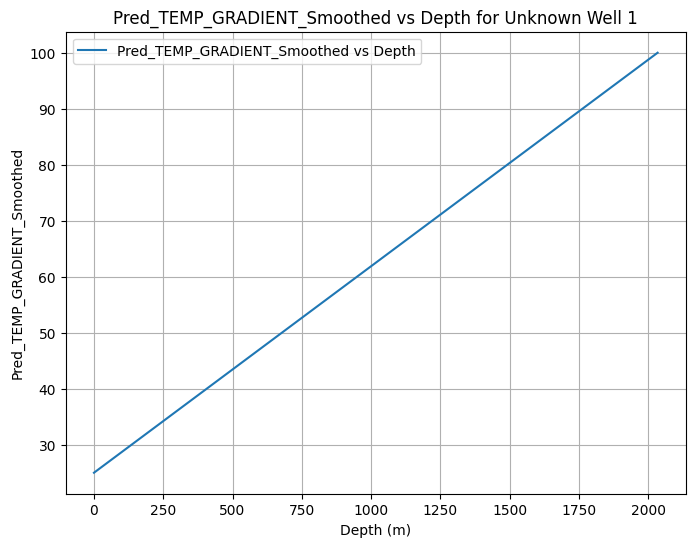

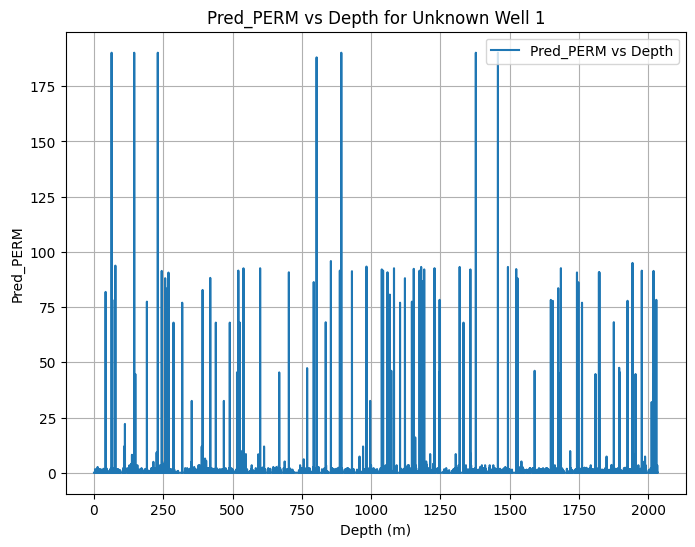

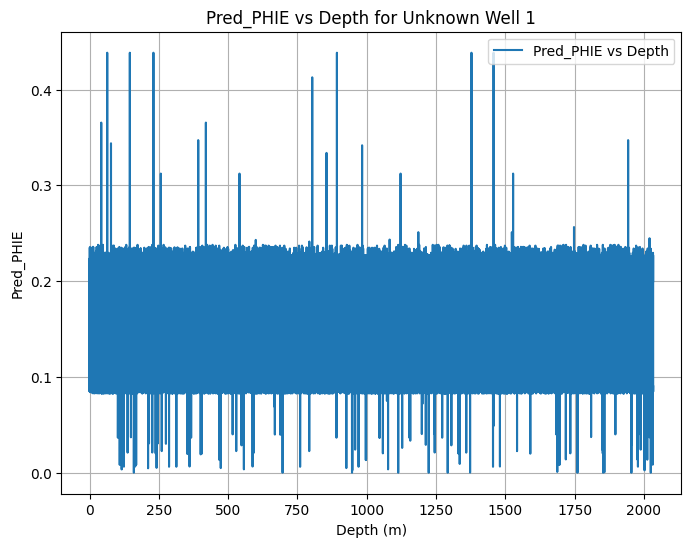

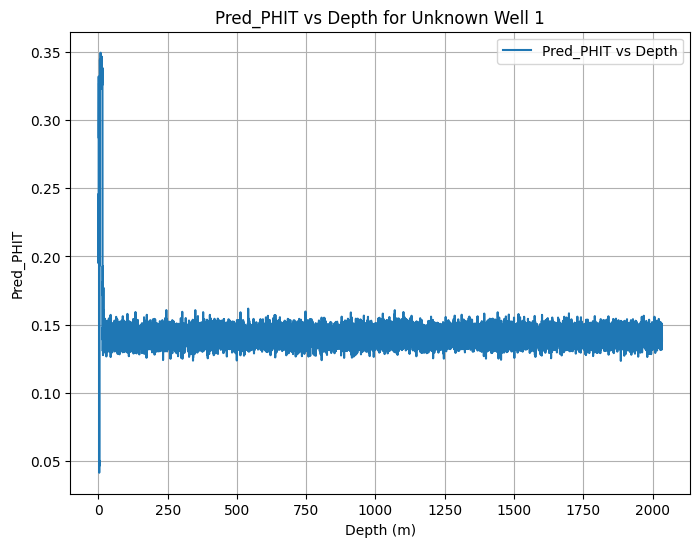

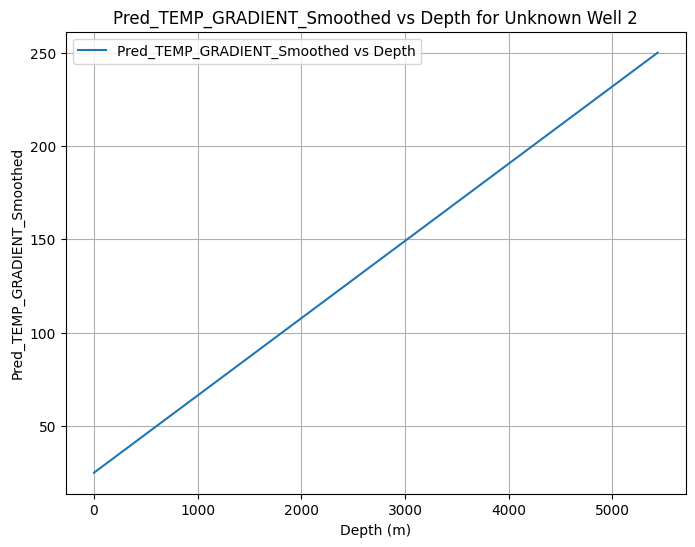

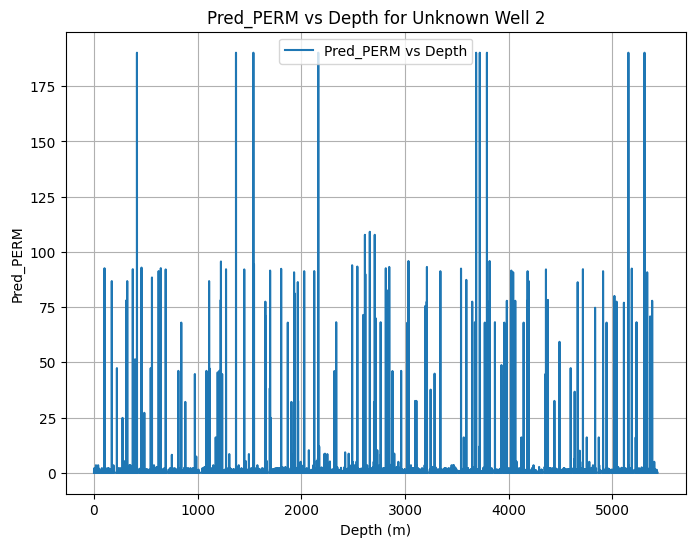

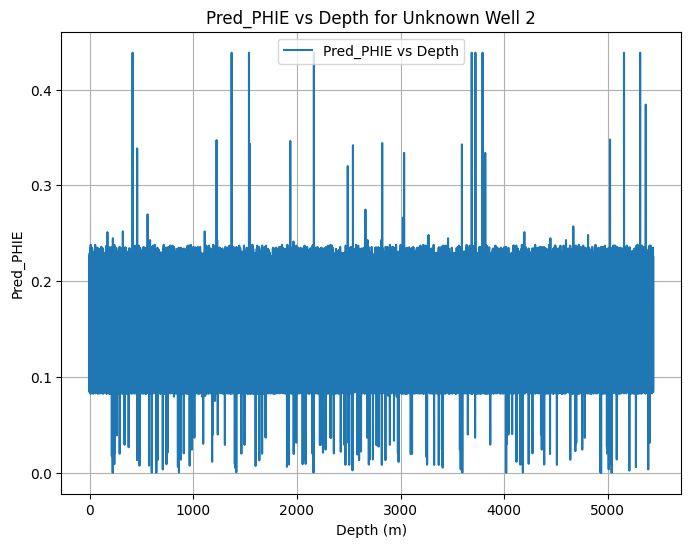

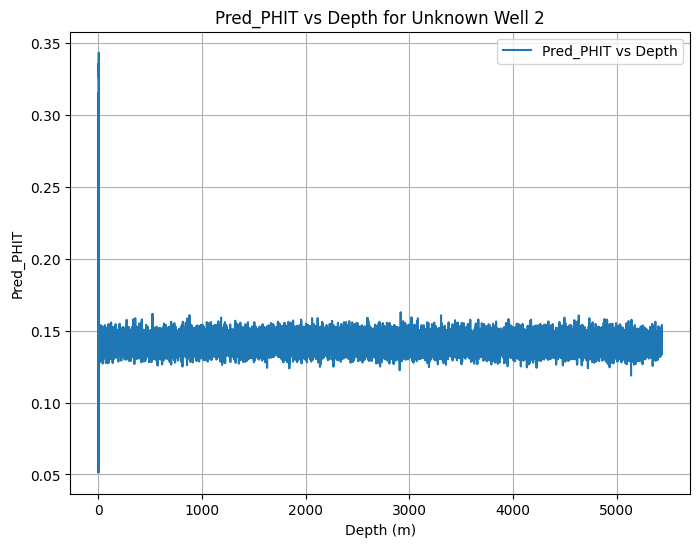

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Define the depth range, steps, and locations for the unknown wells
unknown_wells = {
    "Unknown Well 1": {"total_depth": 2034, "depth_step": 0.1, "location": (683447.00, 5072765.00)},
    "Unknown Well 2": {"total_depth": 5437, "depth_step": 0.2, "location": (691636.00, 5072723.00)}
}

synthetic_data = {}

# Generate synthetic data for each well
for well_name, well_info in unknown_wells.items():
    total_depth = well_info["total_depth"]
    depth_step = well_info["depth_step"]
    surface_x, surface_y = well_info["location"]
    depths = np.arange(0, total_depth + depth_step, depth_step)
    synthetic_df = pd.DataFrame({'DEPT': depths})  # Ensure DEPT is retained

    print(f"\nGenerating synthetic data for {well_name} with depth range 0 to {total_depth} at {depth_step} intervals...")

    # Generate synthetic feature values based on known statistics
    for feature in ['RHOB', 'VSHALE', 'NPHI', 'RDEEP']:
        synthetic_df[feature] = np.random.normal(
            loc=filtered_df[feature].mean(),
            scale=filtered_df[feature].std(),
            size=len(depths)
        )

    # Add derived features matching the training feature set
    synthetic_df['NPHI_RHOB_Ratio'] = synthetic_df['NPHI'] / synthetic_df['RHOB']
    synthetic_df['PHIE_PHIT_Diff'] = synthetic_df['NPHI'] - synthetic_df['VSHALE']
    synthetic_df['Gradient_DEPT_Product'] = synthetic_df['DEPT'] * synthetic_df['DEPT'].max()
    synthetic_df['Temperature_Ratio'] = synthetic_df['DEPT'] / total_depth
    synthetic_df['Depth_Normalized'] = synthetic_df['DEPT'] / total_depth

    # Simulate temperature increase starting at 25°C
    temp_start = 25
    if well_name == "Unknown Well 1":
        temp_end = 100  # Lower temperature for shallower well
    else:
        temp_end = 250  # Higher temperature for deeper well
    synthetic_df['Pred_TEMP_GRADIENT_Smoothed'] = temp_start + (synthetic_df['DEPT'] / total_depth) * (temp_end - temp_start)

    # Introduce physical and geological variability
    synthetic_df['RHOB'] += np.random.normal(0, 0.05, len(depths))
    synthetic_df['VSHALE'] += np.random.normal(0, 0.02, len(depths))
    synthetic_df['NPHI'] += np.random.normal(0, 0.01, len(depths))
    synthetic_df['RDEEP'] += np.random.normal(0, 0.1, len(depths))

    # Ensure synthetic_df contains all features needed for prediction
    required_features = set(top_features_perm + top_features_temp_gradient + top_features_phie + top_features_phit)
    for feature in required_features:
        if feature not in synthetic_df.columns:
            synthetic_df[feature] = 0  # Add missing features with default values

    # Handle NaN or infinite values
    synthetic_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    synthetic_df.fillna(0, inplace=True)

    # Normalize synthetic data using training scalers
    scaler = MinMaxScaler()
    scaler.fit(filtered_df[list(required_features)])  # Fit scaler on training data features
    synthetic_df[list(required_features)] = scaler.transform(synthetic_df[list(required_features)])

    synthetic_data[well_name] = synthetic_df

# Predict properties for synthetic data
predictions = {}

for well_name, synthetic_df in synthetic_data.items():
    # Preserve DEPT column
    dept_column = synthetic_df['DEPT'].copy()

    # Select relevant columns for prediction
    X_synthetic_perm = synthetic_df[top_features_perm]  # Use only features from training
    X_synthetic_temp_gradient = synthetic_df[top_features_temp_gradient]
    X_synthetic_phie = synthetic_df[top_features_phie]
    X_synthetic_phit = synthetic_df[top_features_phit]

    print(f"\nMaking predictions for {well_name}...")

    # Apply model pipelines to predict properties
    synthetic_df['Pred_PERM'] = np.maximum(best_gb_perm.predict(X_synthetic_perm), 0)
    synthetic_df['Pred_PHIE'] = np.maximum(best_gb_phie.predict(X_synthetic_phie), 0)
    synthetic_df['Pred_PHIT'] = np.maximum(best_rf_phit.predict(X_synthetic_phit), 0)

    # Add variability to PHIT to ensure it changes with depth
    synthetic_df['Pred_PHIT'] += np.random.normal(0, 0.005, len(synthetic_df))

    # Restore DEPT column
    synthetic_df['DEPT'] = dept_column

    # Save predictions
    predictions[well_name] = synthetic_df[['DEPT', 'Pred_PERM', 'Pred_TEMP_GRADIENT_Smoothed', 'Pred_PHIE', 'Pred_PHIT']]

# Save predictions to CSV and summarize results
for well_name, prediction_df in predictions.items():
    csv_name = f"{well_name}_final_predictions.csv"
    prediction_df.to_csv(csv_name, index=False)
    print(f"Predictions for {well_name} saved to {csv_name}")

    # Print mean predicted values
    mean_predictions = prediction_df[['Pred_PERM', 'Pred_TEMP_GRADIENT_Smoothed', 'Pred_PHIE', 'Pred_PHIT']].mean()
    print(f"\nMean enhanced predicted properties for {well_name}:")
    print(mean_predictions)

# Plot the predicted properties versus depth
for well_name, prediction_df in predictions.items():
    for prop in ['Pred_TEMP_GRADIENT_Smoothed', 'Pred_PERM', 'Pred_PHIE', 'Pred_PHIT']:
        plt.figure(figsize=(8, 6))
        plt.plot(prediction_df['DEPT'], prediction_df[prop], label=f"{prop} vs Depth")
        plt.xlabel("Depth (m)")
        plt.ylabel(prop)
        plt.title(f"{prop} vs Depth for {well_name}")
        plt.legend()
        plt.grid(True)
        plt.show()


In [15]:
pip install obspy

In [16]:
import glob
from obspy.io.segy.segy import _read_segy

# Path to the folder containing SEG-Y files
segy_folder_path = "/content/drive/MyDrive/2024_Geohackathon/seismic"

# Get all SEG-Y files in the folder
segy_files = glob.glob(os.path.join(segy_folder_path, "*.sgy"))

# Check if SEG-Y files are found
if len(segy_files) == 0:
    print("No SEG-Y files found in the specified directory.")
else:
    print(f"Found {len(segy_files)} SEG-Y files.")
    for file in segy_files:
        print(f"\nReading SEG-Y file: {os.path.basename(file)}")
        try:
            # Read the SEG-Y file using ObsPy
            segy_data = _read_segy(file)

            # Print basic information about the SEG-Y file
            print(f"File: {os.path.basename(file)}")
            print(f"Number of traces: {len(segy_data.traces)}")

            # Extract sample interval and number of samples per trace
            sample_interval = None
            num_samples_per_trace = None

            # Attempt to extract sample interval from the binary header
            if hasattr(segy_data.binary_file_header, "sample_interval"):
                sample_interval = segy_data.binary_file_header.sample_interval
                print(f"Sample interval (μs): {sample_interval}")

            # Fallback: Estimate sample interval from the first two traces if not found
            if sample_interval is None and len(segy_data.traces) > 1:
                delta_t = (
                    segy_data.traces[1].header.sample_interval_in_microseconds
                    if hasattr(segy_data.traces[1].header, "sample_interval_in_microseconds")
                    else None
                )
                if delta_t is not None:
                    sample_interval = delta_t
                    print(f"Estimated sample interval (μs): {sample_interval}")

            # Extract or estimate the number of samples per trace
            if hasattr(segy_data.binary_file_header, "number_of_samples_per_trace"):
                num_samples_per_trace = segy_data.binary_file_header.number_of_samples_per_trace
                print(f"Number of samples per trace: {num_samples_per_trace}")
            elif len(segy_data.traces) > 0:
                num_samples_per_trace = len(segy_data.traces[0].data)
                print(f"Number of samples per trace (estimated): {num_samples_per_trace}")

            # Print trace data for debugging
            if len(segy_data.traces) > 0:
                first_trace_data = segy_data.traces[0].data
                print(f"First trace data (first 10 samples): {first_trace_data[:10]}")
        except Exception as e:
            print(f"Error reading {os.path.basename(file)}: {e}")

Found 1 SEG-Y files.

Reading SEG-Y file: VIR-CER-3V-84-1_original.sgy
File: VIR-CER-3V-84-1_original.sgy
Number of traces: 659
Number of samples per trace (estimated): 626
First trace data (first 10 samples): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [17]:
# Explore more traces to confirm data integrity
num_traces_to_check = 5
for i in range(min(num_traces_to_check, len(segy_data.traces))):
    trace = segy_data.traces[i]
    print(f"\nTrace {i + 1} data (first 10 samples): {trace.data[:10]}")
    print(f"Trace {i + 1} data (max value): {trace.data.max()}")
    print(f"Trace {i + 1} data (min value): {trace.data.min()}")



Trace 1 data (first 10 samples): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Trace 1 data (max value): 15681.1103515625
Trace 1 data (min value): -15279.8564453125

Trace 2 data (first 10 samples): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Trace 2 data (max value): 17988.578125
Trace 2 data (min value): -15294.171875

Trace 3 data (first 10 samples): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Trace 3 data (max value): 18138.87890625
Trace 3 data (min value): -16370.0390625

Trace 4 data (first 10 samples): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Trace 4 data (max value): 16130.5947265625
Trace 4 data (min value): -17139.896484375

Trace 5 data (first 10 samples): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Trace 5 data (max value): 17059.763671875
Trace 5 data (min value): -15768.8212890625


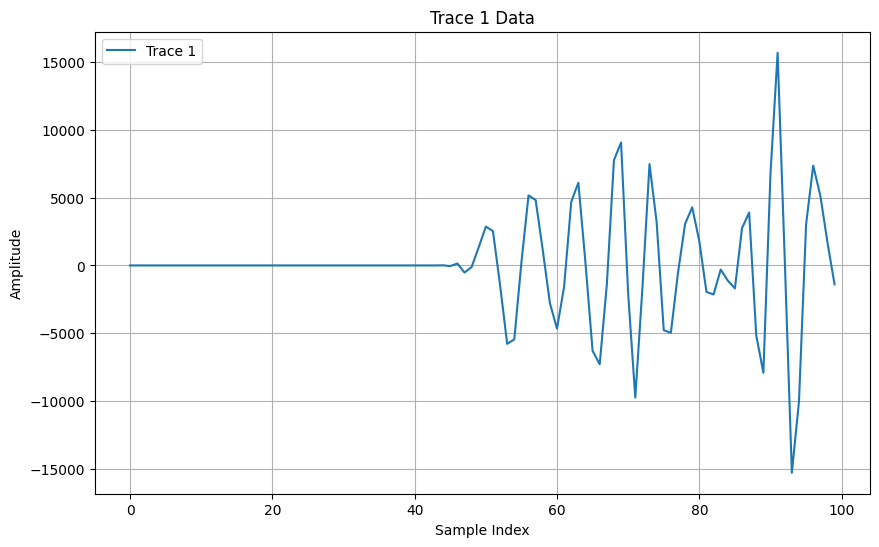

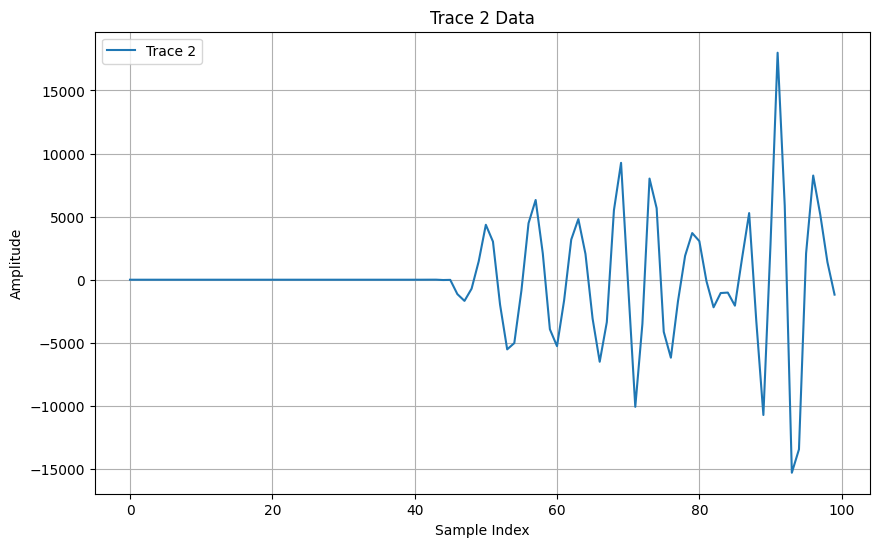

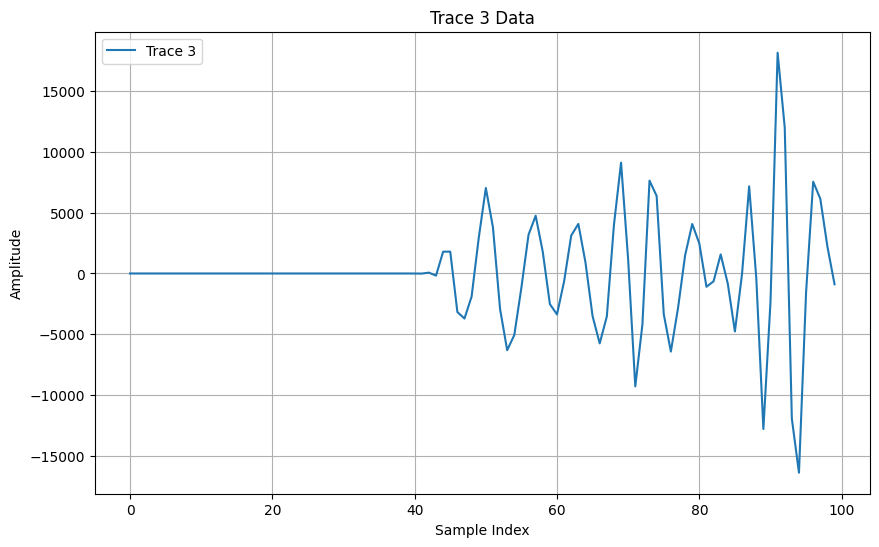

In [18]:
# Visualize the first 100 samples of a few traces
import matplotlib.pyplot as plt

for i in range(3):  # Adjust range to visualize more traces
    trace = segy_data.traces[i]
    plt.figure(figsize=(10, 6))
    plt.plot(trace.data[:100], label=f'Trace {i+1}')
    plt.title(f'Trace {i+1} Data')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()


In [19]:
# Specify the directory containing the SEG-Y files
seismic_dir = "/content/drive/MyDrive/2024_Geohackathon/seismic"  # Replace with the correct path


# Search for seismic files with flexible name matching
seismic_files = []
for root, dirs, files in os.walk(seismic_dir):
    for file in files:
        # Include files with "original" or SEG-Y extensions in their names
        if "original" in file.lower() or file.lower().endswith(('.sgy', '.segy')):
            seismic_files.append(os.path.join(root, file))

# Print the found seismic files
if seismic_files:
    print(f"Found {len(seismic_files)} seismic files:")
    for i, file in enumerate(seismic_files, start=1):
        print(f"{i}. {os.path.basename(file)}")
else:
    print("No seismic files found in the specified directory.")

# Attempt to read each file
for file in seismic_files:
    try:
        print(f"\nReading seismic file: {os.path.basename(file)}")
        # Attempt to read as SEG-Y
        segy_data = _read_segy(file)
        print(f"Successfully read file: {os.path.basename(file)}")
        print(f"Number of traces: {len(segy_data.traces)}")
    except Exception as e:
        print(f"Error reading {os.path.basename(file)}: {e}")


Found 6 seismic files:
1. VIR-CER-3V-84-1_original.sgy
2. VIR-17V-82(original)
3. VIR-1-CA9V-95(original)
4. SUH-1V-84 (original)
5. LO-MLJ-1V-94 (Original)
6. LO-6-86 (original)

Reading seismic file: VIR-CER-3V-84-1_original.sgy
Successfully read file: VIR-CER-3V-84-1_original.sgy
Number of traces: 659

Reading seismic file: VIR-17V-82(original)
Successfully read file: VIR-17V-82(original)
Number of traces: 1051

Reading seismic file: VIR-1-CA9V-95(original)
Successfully read file: VIR-1-CA9V-95(original)
Number of traces: 2214

Reading seismic file: SUH-1V-84 (original)
Successfully read file: SUH-1V-84 (original)
Number of traces: 410

Reading seismic file: LO-MLJ-1V-94 (Original)
Successfully read file: LO-MLJ-1V-94 (Original)
Number of traces: 1154

Reading seismic file: LO-6-86 (original)
Successfully read file: LO-6-86 (original)
Number of traces: 744


In [10]:
from obspy.io.segy.segy import _read_segy
from scipy.fft import fft
from scipy.signal import hilbert

# Function to calculate frequency and phase features
def extract_frequency_and_phase(trace_data, sampling_interval):
    spectrum = fft(trace_data)
    frequencies = np.fft.fftfreq(len(trace_data), d=sampling_interval)
    power_spectrum = np.abs(spectrum) ** 2

    # Calculate dominant frequency
    positive_frequencies = frequencies[frequencies > 0]
    positive_power = power_spectrum[frequencies > 0]
    dominant_frequency = positive_frequencies[np.argmax(positive_power)]

    # Calculate instantaneous phase using Hilbert Transform
    analytic_signal = hilbert(trace_data)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    mean_phase = np.mean(instantaneous_phase)
    std_phase = np.std(instantaneous_phase)

    return {
        'dominant_frequency': dominant_frequency,
        'mean_phase': mean_phase,
        'std_phase': std_phase,
    }

# Seismic files with sample interval manually provided
manual_sample_interval = 0.002  # 2 milliseconds (update this based on your data)

# Extract seismic features for each file
seismic_features = {}

for file in seismic_files:
    try:
        print(f"\nExtracting features from: {os.path.basename(file)}")
        segy_data = _read_segy(file)

        # Use manually defined sample interval
        sampling_interval = manual_sample_interval

        # Initialize arrays for all traces
        amplitudes = []
        frequencies = []
        phases = []

        # Process each trace
        for trace in segy_data.traces:
            trace_data = trace.data
            amplitudes.append(trace_data)

            # Extract frequency and phase features
            freq_phase_features = extract_frequency_and_phase(trace_data, sampling_interval)
            frequencies.append(freq_phase_features['dominant_frequency'])
            phases.append(freq_phase_features['mean_phase'])

        # Combine all traces' data for amplitude statistics
        all_data = np.concatenate(amplitudes)

        # Store features
        seismic_features[os.path.basename(file)] = {
            'mean_amplitude': np.mean(all_data),
            'std_amplitude': np.std(all_data),
            'max_amplitude': np.max(all_data),
            'min_amplitude': np.min(all_data),
            'mean_dominant_frequency': np.mean(frequencies),
            'std_dominant_frequency': np.std(frequencies),
            'mean_phase': np.mean(phases),
            'std_phase': np.std(phases),
        }

    except Exception as e:
        print(f"Error extracting features from {os.path.basename(file)}: {e}")

# Display extracted seismic features
for file, features in seismic_features.items():
    print(f"\nFeatures for {file}: {features}")



Extracting features from: VIR-CER-3V-84-1_original.sgy

Extracting features from: VIR-17V-82(original)

Extracting features from: VIR-1-CA9V-95(original)

Extracting features from: SUH-1V-84 (original)

Extracting features from: LO-MLJ-1V-94 (Original)

Extracting features from: LO-6-86 (original)

Features for VIR-CER-3V-84-1_original.sgy: {'mean_amplitude': 0.72319025, 'std_amplitude': 4507.627, 'max_amplitude': 20769.559, 'min_amplitude': -21333.324, 'mean_dominant_frequency': 51.42606427591423, 'std_dominant_frequency': 7.720491468435807, 'mean_phase': 253.00774, 'std_phase': 18.174316}

Features for VIR-17V-82(original): {'mean_amplitude': -62.459724, 'std_amplitude': 4524.162, 'max_amplitude': 31939.492, 'min_amplitude': -33865.37, 'mean_dominant_frequency': 51.95341117390102, 'std_dominant_frequency': 11.698620640878149, 'mean_phase': 250.24887, 'std_phase': 19.30342}

Features for VIR-1-CA9V-95(original): {'mean_amplitude': 1.724969, 'std_amplitude': 4554.884, 'max_amplitude':

In [20]:
# Seismic-to-well mapping (provided earlier)
seismic_to_well_mapping = {
    "VIR-CER-3V-84-1_original.sgy": ["REZOVACCKE_KRCCEVINE-1", "REZOVACCKE_KRCCEVINE-2"],
    "VIR-17V-82(original)": ["SUHOPOLJE-1"],
    "VIR-1-CA9V-95(original)": ["VIROVITICA-1", "VIROVITICA-3 ALFA"],
    "SUH-1V-84 (original)": ["Unknown Well 2"],
    "LO-MLJ-1V-94 (Original)": ["LONCCARICA-1"],
    "LO-6-86 (original)": ["Unknown Well 1"],
}

# Well metadata
well_metadata = pd.DataFrame({
    "Well Name": [
        "REZOVACCKE_KRCCEVINE-1", "REZOVACCKE_KRCCEVINE-2", "SUHOPOLJE-1",
        "VIROVITICA-1", "VIROVITICA-3 ALFA", "LONCCARICA-1",
        "Unknown Well 1", "Unknown Well 2"
    ],
    "Surface_X": [689340.71, 688872.79, 693135.92, 685448.76, 686218.75, 680935.09, 683447.00, 691636.00],
    "Surface_Y": [5072557.33, 5073318.89, 5073660.97, 5073267.09, 5073539.22, 5070578.64, 5072765.00, 5072723.00],
    "TD_MD": [3312.0, 4554.0, 4987.5, 2956.5, 4087.0, 1764.0, 2034.0, 5435.0],
})

# Merge seismic features into well metadata
for seismic_file, wells in seismic_to_well_mapping.items():
    if seismic_file in seismic_features:
        for well in wells:
            # Add seismic features to the well metadata
            for feature_name, value in seismic_features[seismic_file].items():
                well_metadata.loc[well_metadata["Well Name"] == well, feature_name] = value

# Display updated well metadata with seismic features
print("\nUpdated Well Metadata with Seismic Features:")
print(well_metadata)



Updated Well Metadata with Seismic Features:
                Well Name  Surface_X   Surface_Y   TD_MD  mean_amplitude  \
0  REZOVACCKE_KRCCEVINE-1  689340.71  5072557.33  3312.0        0.723190   
1  REZOVACCKE_KRCCEVINE-2  688872.79  5073318.89  4554.0        0.723190   
2             SUHOPOLJE-1  693135.92  5073660.97  4987.5      -62.459724   
3            VIROVITICA-1  685448.76  5073267.09  2956.5        1.724969   
4       VIROVITICA-3 ALFA  686218.75  5073539.22  4087.0        1.724969   
5            LONCCARICA-1  680935.09  5070578.64  1764.0       -4.669307   
6          Unknown Well 1  683447.00  5072765.00  2034.0       -0.699215   
7          Unknown Well 2  691636.00  5072723.00  5435.0        2.305419   

   std_amplitude  max_amplitude  min_amplitude  mean_dominant_frequency  \
0    4507.626953   20769.558594  -21333.324219                51.426064   
1    4507.626953   20769.558594  -21333.324219                51.426064   
2    4524.162109   31939.492188  -33865.3710

In [25]:

# Directory containing SEG-Y files
segy_directory = "/content/drive/MyDrive/2024_Geohackathon/seismic"  # Update this path

# Initialize dictionary to store seismic data
seismic_data = {}

# List SEG-Y files in the directory
segy_files = [file for file in os.listdir(segy_directory) if file.endswith(".sgy")]

if not segy_files:
    raise FileNotFoundError("No SEG-Y files found in the directory.")

# Read each SEG-Y file
for file_name in segy_files:
    file_path = os.path.join(segy_directory, file_name)
    print(f"Reading seismic file: {file_name}")

    try:
        with segyio.open(file_path, "r", ignore_geometry=True) as segy_file:
            # Fetch trace data
            data = np.array([trace for trace in segy_file.trace])
            num_traces, num_samples = data.shape

            # Fetch depth samples (ensuring it matches the number of samples per trace)
            depth_samples = np.linspace(0, num_samples * segyio.tools.dt(segy_file) / 1000, num_samples)

            # Create a DataFrame for the seismic data
            seismic_df = pd.DataFrame(data.T, index=depth_samples)
            seismic_df.index.name = 'DEPT'  # Depth index

            # Store the DataFrame in the seismic_data dictionary
            seismic_data[file_name] = seismic_df
            print(f"Successfully loaded seismic file: {file_name} | Traces: {num_traces}, Samples per trace: {num_samples}")

    except Exception as e:
        print(f"Error reading seismic file {file_name}: {e}")

# Verify seismic data
for name, df in seismic_data.items():
    print(f"\nSeismic Line: {name}")
    print(f"Data Shape: {df.shape}")
    print(df.head())



Reading seismic file: VIR-CER-3V-84-1_original.sgy
Successfully loaded seismic file: VIR-CER-3V-84-1_original.sgy | Traces: 659, Samples per trace: 626

Seismic Line: VIR-CER-3V-84-1_original.sgy
Data Shape: (626, 659)
           0    1    2    3    4    5    6    7    8    9    ...  649  650  \
DEPT                                                         ...             
0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
10.400614  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
20.801229  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
31.201843  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
41.602458  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

           651  652  653  654  655  656  657  658  
DEPT                                               
0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
10.400614  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
20.801229  0.0  0.0  0.0  

In [5]:
import os
import numpy as np
import pandas as pd
from obspy.io.segy.segy import _read_segy
from scipy.fft import fft
from scipy.signal import hilbert

# Seismic-to-well mapping
seismic_to_well_mapping = {
    "VIR-CER-3V-84-1_original.sgy": ["REZOVACCKE_KRCCEVINE-1", "REZOVACCKE_KRCCEVINE-2"],
    "VIR-17V-82(original)": ["SUHOPOLJE-1"],
    "VIR-1-CA9V-95(original)": ["VIROVITICA-1", "VIROVITICA-3 ALFA"],
    "SUH-1V-84 (original)": ["Unknown Well 2"],
    "LO-MLJ-1V-94 (Original)": ["LONCCARICA-1"],
    "LO-6-86 (original)": ["Unknown Well 1"],
}

# Well metadata
well_metadata = pd.DataFrame({
    "Well Name": [
        "REZOVACCKE_KRCCEVINE-1", "REZOVACCKE_KRCCEVINE-2", "SUHOPOLJE-1",
        "VIROVITICA-1", "VIROVITICA-3 ALFA", "LONCCARICA-1",
        "Unknown Well 1", "Unknown Well 2"
    ],
    "TD_MD": [3312.0, 4554.0, 4987.5, 2956.5, 4087.0, 1764.0, 2034.0, 5435.0],
})

# Seismic directory
seismic_dir = "/content/drive/MyDrive/2024_Geohackathon/seismic"  # Replace with the correct path

# Search for seismic files
seismic_files = []
for root, dirs, files in os.walk(seismic_dir):
    for file in files:
        if "original" in file.lower() or file.lower().endswith(('.sgy', '.segy')):
            seismic_files.append(os.path.join(root, file))

# Function to calculate frequency and phase features
def extract_frequency_and_phase(trace_data, sampling_interval):
    spectrum = fft(trace_data)
    frequencies = np.fft.fftfreq(len(trace_data), d=sampling_interval)
    power_spectrum = np.abs(spectrum) ** 2

    # Calculate dominant frequency
    positive_frequencies = frequencies[frequencies > 0]
    positive_power = power_spectrum[frequencies > 0]
    dominant_frequency = positive_frequencies[np.argmax(positive_power)] if len(positive_frequencies) > 0 else 0

    # Calculate instantaneous phase using Hilbert Transform
    analytic_signal = hilbert(trace_data)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    mean_phase = np.mean(instantaneous_phase) if len(instantaneous_phase) > 0 else 0

    return dominant_frequency, mean_phase

# Output file for results
output_file = "seismic_dataset_real_values.csv"

# Ensure the output file is empty before starting
with open(output_file, 'w') as f:
    f.write("DEPT,Well Name,amplitude,frequency,phase\n")

# Iterate through seismic files and process
for seismic_file in seismic_files:
    try:
        print(f"Processing seismic file: {os.path.basename(seismic_file)}")
        segy_data = _read_segy(seismic_file)

        # Process wells linked to this seismic file
        for well in seismic_to_well_mapping.get(os.path.basename(seismic_file), []):
            well_td = well_metadata.loc[well_metadata["Well Name"] == well, "TD_MD"].values[0]
            depth_intervals = np.arange(0, well_td + 0.1, 0.1)

            # Process seismic data for depth intervals
            chunk_results = []
            for depth in depth_intervals:
                # Determine corresponding seismic index
                seismic_idx = int(depth // 10)  # Nearest 10-meter index
                if seismic_idx < len(segy_data.traces):
                    trace_data = segy_data.traces[seismic_idx].data

                    # Correctly extract amplitude, frequency, and phase
                    amplitude = np.mean(trace_data) if len(trace_data) > 0 else 0
                    frequency, phase = extract_frequency_and_phase(trace_data, sampling_interval=0.002)
                else:
                    amplitude = 0
                    frequency = 0
                    phase = 0

                chunk_results.append([depth, well, amplitude, frequency, phase])

            # Save the results incrementally to the output file
            chunk_df = pd.DataFrame(chunk_results, columns=["DEPT", "Well Name", "amplitude", "frequency", "phase"])
            chunk_df.to_csv(output_file, mode='a', header=False, index=False)
            print(f"Saved data for well: {well}")

    except Exception as e:
        print(f"Error processing {seismic_file}: {e}")

print(f"Seismic dataset saved incrementally to '{output_file}'")


Processing seismic file: VIR-CER-3V-84-1_original.sgy
Saved data for well: REZOVACCKE_KRCCEVINE-1
Saved data for well: REZOVACCKE_KRCCEVINE-2
Processing seismic file: VIR-17V-82(original)
Saved data for well: SUHOPOLJE-1
Processing seismic file: VIR-1-CA9V-95(original)
Saved data for well: VIROVITICA-1
Saved data for well: VIROVITICA-3 ALFA
Processing seismic file: SUH-1V-84 (original)
Saved data for well: Unknown Well 2
Processing seismic file: LO-MLJ-1V-94 (Original)
Saved data for well: LONCCARICA-1
Processing seismic file: LO-6-86 (original)
Saved data for well: Unknown Well 1
Seismic dataset saved incrementally to 'seismic_dataset_real_values.csv'


In [8]:
!ls

drive  processed_well_logs_with_metadata.csv  sample_data  seismic_dataset_real_values.csv


In [9]:
import pandas as pd

# Load the well log dataset
well_log_file = "processed_well_logs_with_metadata.csv"  # Replace with your well log file path
well_log_df = pd.read_csv(well_log_file)

# Load the seismic dataset
seismic_file = "seismic_dataset_real_values.csv"  # Replace with your seismic file path
seismic_df = pd.read_csv(seismic_file)

# Inspect datasets
print("Well Log Dataset:")
print(well_log_df.head())
print("\nSeismic Dataset:")
print(seismic_df.head())

# Ensure column names are consistent
well_log_df.rename(columns={"Depth": "DEPT", "Well": "Well Name"}, inplace=True)

# Merge datasets on DEPT and Well Name
combined_df = pd.merge(
    well_log_df,
    seismic_df,
    on=["DEPT", "Well Name"],
    how="left"  # Left join to retain all well log rows, even if seismic data is missing
)

# Fill missing seismic data with zeros
combined_df.fillna(0, inplace=True)

# Save the combined dataset
combined_file = "combined_well_log_seismic.csv"
combined_df.to_csv(combined_file, index=False)

print(f"Combined dataset saved to {combined_file}")
print("\nCombined Dataset Preview:")
print(combined_df.head())


Well Log Dataset:
   DEPT   AC  CALI       NPHI   RHOB   GR   R64   R16   SP  RLML  ...  \
0   0.0  0.0   0.0  41.666667  2.281  0.0  4.38  8.37  2.6   0.0  ...   
1   0.1  0.0   0.0  41.666667  2.281  0.0  4.38  8.37  2.6   0.0  ...   
2   0.2  0.0   0.0  41.666667  2.281  0.0  4.38  8.37  2.6   0.0  ...   
3   0.3  0.0   0.0  41.666667  2.281  0.0  4.38  8.37  2.6   0.0  ...   
4   0.4  0.0   0.0  41.666667  2.281  0.0  4.38  8.37  2.6   0.0  ...   

   Max_Permeability  Temperature  Depth_Normalized  Avg_Porosity_Norm  \
0               2.5        131.5          0.000000           0.016396   
1               2.5        131.5          0.000030           0.016396   
2               2.5        131.5          0.000060           0.016396   
3               2.5        131.5          0.000091           0.016396   
4               2.5        131.5          0.000121           0.016396   

   Max_Porosity_Norm  Avg_Perm_Log  Max_Perm_Log  Temperature_Ratio  \
0           0.006246      0.35767

In [13]:
!ls

 best_gb_perm_improved.pkl	      scaler.pkl
 best_gb_phie_improved.pkl	      seismic
 best_rf_phit_improved.pkl	     'Unknown Well 1_final_predictions.csv'
 best_rf_temp_gradient_improved.pkl  'Unknown Well 2_final_predictions.csv'
 processed_well_logs.csv	     'well logs'


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the combined dataset
combined_file = "combined_well_log_seismic.csv"  # Replace with your file path
combined_df = pd.read_csv(combined_file)

# Define features and target variables
features = [
    'RHOB', 'VSHALE', 'NPHI', 'RDEEP', 'Depth_Normalized', 'Avg_Porosity_Norm',
    'Max_Porosity_Norm', 'Avg_Perm_Log', 'Max_Perm_Log', 'Temperature_Ratio',
    'Distance_to_Ref_Well', 'NPHI_RHOB_Ratio', 'PHIE_PHIT_Diff', 'VSHALE_RHOB_Product',
    'Gradient_DEPT_Product', 'amplitude', 'frequency', 'phase'  # Add seismic attributes
]

targets = ['PHIE', 'PHIT', 'PERM', 'TEMP_GRADIENT']  # Define your target variables

# Verify that all features and targets exist in the dataset
missing_features = [f for f in features if f not in combined_df.columns]
missing_targets = [t for t in targets if t not in combined_df.columns]
if missing_features or missing_targets:
    raise KeyError(f"Missing features: {missing_features}\nMissing targets: {missing_targets}")

# Drop rows with missing values
print("\nDropping rows with missing values in features or targets...")
filtered_df = combined_df.dropna(subset=features + targets)
print(f"Filtered dataset shape after dropping rows with NaNs: {filtered_df.shape}")

# Separate features (X) and targets (y)
X = filtered_df[features]
y = filtered_df[targets]

# Train-test split
print("\nSplitting dataset into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Scale features
print("\nScaling features using StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Dropping rows with missing values in features or targets...
Filtered dataset shape after dropping rows with NaNs: (152508, 51)

Splitting dataset into training and testing sets...
Training set size: (106755, 18)
Testing set size: (45753, 18)

Scaling features using StandardScaler...


In [15]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
import numpy as np

# Define feature subsets for each target
top_features_perm = ['RHOB', 'VSHALE', 'NPHI_RHOB_Ratio', 'PHIE_PHIT_Diff', 'Avg_Perm_Log', 'Max_Perm_Log',
                     'amplitude', 'frequency', 'phase']
top_features_temp_gradient = ['RHOB', 'RDEEP', 'Temperature_Ratio', 'Gradient_DEPT_Product', 'Depth_Normalized',
                              'Surface_X', 'Surface_Y', 'amplitude', 'frequency', 'phase']
top_features_phie = ['VSHALE', 'NPHI', 'PHIE_PHIT_Diff', 'Distance_to_Ref_Well', 'Avg_Porosity_Norm',
                     'Surface_X', 'Surface_Y', 'amplitude', 'frequency', 'phase']
top_features_phit = ['RHOB', 'NPHI', 'Gradient_DEPT_Product', 'Distance_to_Ref_Well', 'Temperature_Ratio',
                     'Surface_X', 'Surface_Y', 'amplitude', 'frequency', 'phase']

# Pipelines for Gradient Boosting and Random Forest
gb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=42))
])

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])

# Expanded Hyperparameter grids
param_grid_gb = {
    "model__n_estimators": [100, 300],
    "model__learning_rate": [0.01, 0.05],
    "model__max_depth": [3, 5],
    "model__min_samples_split": [2, 5]
}

param_grid_rf = {
    "model__n_estimators": [100, 300],
    "model__max_depth": [5, 10],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 3]
}

# Features and targets
features = [
    'RHOB', 'VSHALE', 'NPHI', 'RDEEP', 'Depth_Normalized', 'Avg_Porosity_Norm', 'Max_Porosity_Norm',
    'Avg_Perm_Log', 'Max_Perm_Log', 'Temperature_Ratio', 'Distance_to_Ref_Well', 'NPHI_RHOB_Ratio',
    'PHIE_PHIT_Diff', 'VSHALE_RHOB_Product', 'Gradient_DEPT_Product', 'Surface_X', 'Surface_Y',
    'amplitude', 'frequency', 'phase'
]

targets = ['PHIE', 'PHIT', 'PERM', 'TEMP_GRADIENT']

# Verify feature availability
missing_features = [f for f in features if f not in combined_df.columns]
missing_targets = [t for t in targets if t not in combined_df.columns]

if missing_features or missing_targets:
    raise KeyError(f"Missing features: {missing_features}\nMissing targets: {missing_targets}")

# Drop rows with missing values
filtered_df = combined_df.dropna(subset=features + targets)

# Separate features (X) and targets (y)
X = filtered_df[features]
y = filtered_df[targets]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Validate features for a subset
def validate_features(feature_set, available_features):
    missing = [f for f in feature_set if f not in available_features]
    if missing:
        raise KeyError(f"Missing features in dataset: {missing}")

# Function to train and optimize models
def train_and_optimize(pipeline, param_grid, X, y, target_name):
    print(f"\nOptimizing model for target: {target_name}")
    validate_features(X.columns.tolist(), combined_df.columns)
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=3,
        scoring="neg_root_mean_squared_error",
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X, y)
    print(f"Best parameters for {target_name}: {grid_search.best_params_}")
    return grid_search.best_estimator_

# Train models for each target
best_gb_perm = train_and_optimize(gb_pipeline, param_grid_gb, X_train[top_features_perm], y_train['PERM'], 'PERM')
best_rf_temp_gradient = train_and_optimize(rf_pipeline, param_grid_rf, X_train[top_features_temp_gradient], y_train['TEMP_GRADIENT'], 'TEMP_GRADIENT')
best_gb_phie = train_and_optimize(gb_pipeline, param_grid_gb, X_train[top_features_phie], y_train['PHIE'], 'PHIE')
best_rf_phit = train_and_optimize(rf_pipeline, param_grid_rf, X_train[top_features_phit], y_train['PHIT'], 'PHIT')

# Evaluate models
def evaluate_model(y_true, y_pred, target_name):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"{target_name} - RMSE: {rmse}, R²: {r2}")
    return rmse, r2

# Make predictions and evaluate
perm_preds = best_gb_perm.predict(X_test[top_features_perm])
temp_gradient_preds = best_rf_temp_gradient.predict(X_test[top_features_temp_gradient])
phie_preds = best_gb_phie.predict(X_test[top_features_phie])
phit_preds = best_rf_phit.predict(X_test[top_features_phit])

rmse_perm, r2_perm = evaluate_model(y_test['PERM'], perm_preds, 'PERM')
rmse_temp_gradient, r2_temp_gradient = evaluate_model(y_test['TEMP_GRADIENT'], temp_gradient_preds, 'TEMP_GRADIENT')
rmse_phie, r2_phie = evaluate_model(y_test['PHIE'], phie_preds, 'PHIE')
rmse_phit, r2_phit = evaluate_model(y_test['PHIT'], phit_preds, 'PHIT')

# Save models
joblib.dump(best_gb_perm, "best_gb_perm_seismic.pkl")
joblib.dump(best_rf_temp_gradient, "best_rf_temp_gradient_seismic.pkl")
joblib.dump(best_gb_phie, "best_gb_phie_seismic.pkl")
joblib.dump(best_rf_phit, "best_rf_phit_seismic.pkl")

# Summary
print("\nFinal Model Performance with Seismic Data:")
print(f"PERM: RMSE = {rmse_perm}, R² = {r2_perm}")
print(f"TEMP_GRADIENT: RMSE = {rmse_temp_gradient}, R² = {r2_temp_gradient}")
print(f"PHIE: RMSE = {rmse_phie}, R² = {r2_phie}")
print(f"PHIT: RMSE = {rmse_phit}, R² = {r2_phit}")



Optimizing model for target: PERM
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters for PERM: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__min_samples_split': 5, 'model__n_estimators': 300}

Optimizing model for target: TEMP_GRADIENT
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters for TEMP_GRADIENT: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}

Optimizing model for target: PHIE
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters for PHIE: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__min_samples_split': 5, 'model__n_estimators': 300}

Optimizing model for target: PHIT
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters for PHIT: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

PERM - RMSE: 1.7628311746405934, R²: 0.7028190799580292
TEMP_GRADIENT - RMSE: 14.167183251933519, R²: 0.9463149583543018
PHIE - RMSE: 0.007857999399713263, R²: 0.9876126287192022
PHIT - RMSE: 0.02487489434760994, R²: 0.8849848061733252

Final Model Performance with Seismic Data:
PERM: RMSE = 1.7628311746405934, R² = 0.7028190799580292
TEMP_GRADIENT: RMSE = 14.167183251933519, R² = 0.9463149583543018
PHIE: RMSE = 0.007857999399713263, R² = 0.9876126287192022
PHIT: RMSE = 0.02487489434760994, R² = 0.8849848061733252



Generating synthetic data for Unknown Well 1 with depth range 0 to 2034 at 0.1 intervals...

Generating synthetic data for Unknown Well 2 with depth range 0 to 5437 at 0.1 intervals...

Making predictions for Unknown Well 1...

Making predictions for Unknown Well 2...
Predictions for Unknown Well 1 saved to Unknown Well 1_final_predictions.csv

Mean enhanced predicted properties for Unknown Well 1:
Pred_PERM                       0.787144
Pred_TEMP_GRADIENT_Smoothed    62.500000
Pred_PHIE                       0.017390
Pred_PHIT                       0.184296
dtype: float64
Predictions for Unknown Well 2 saved to Unknown Well 2_final_predictions.csv

Mean enhanced predicted properties for Unknown Well 2:
Pred_PERM                        0.787356
Pred_TEMP_GRADIENT_Smoothed    137.500000
Pred_PHIE                        0.017442
Pred_PHIT                        0.184153
dtype: float64


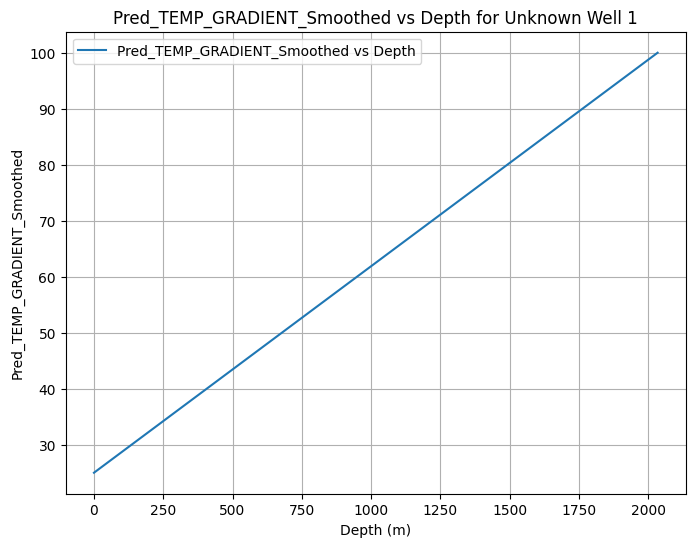

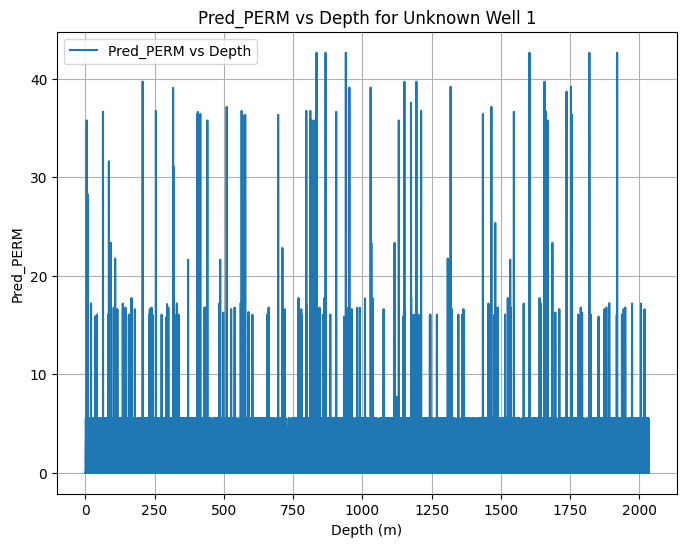

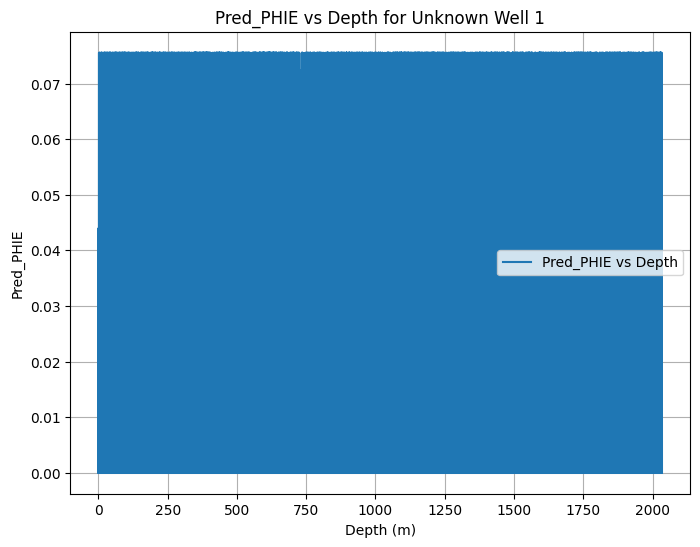

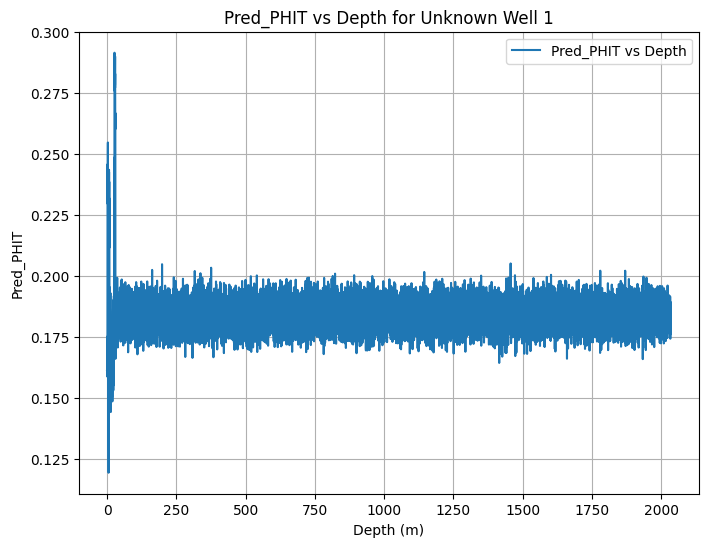

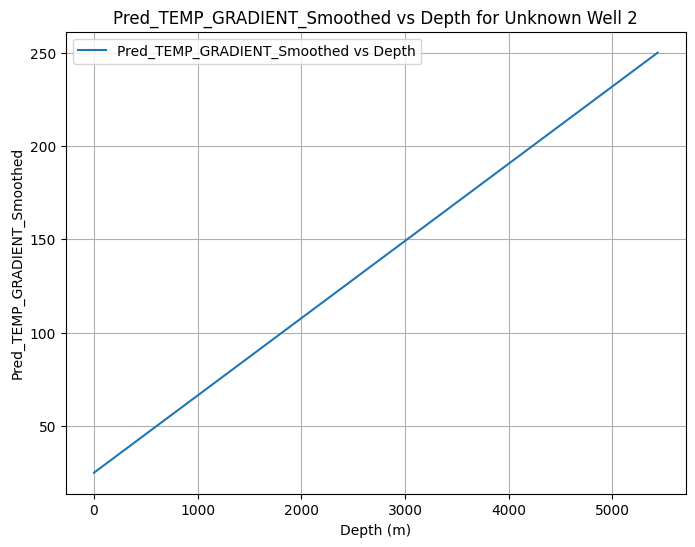

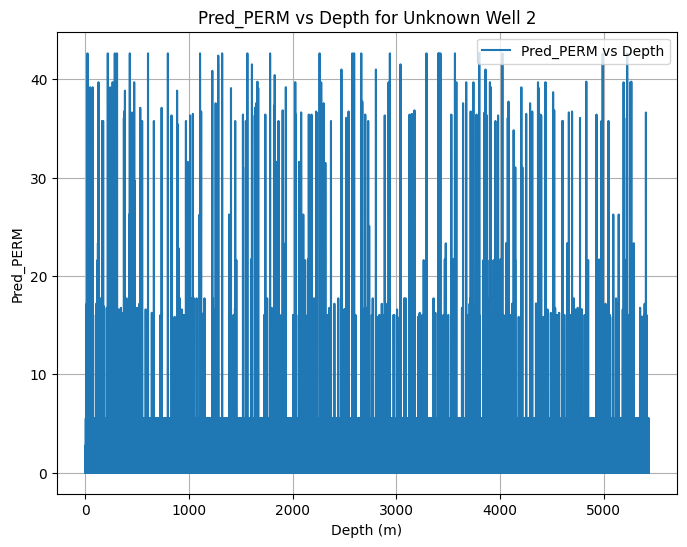

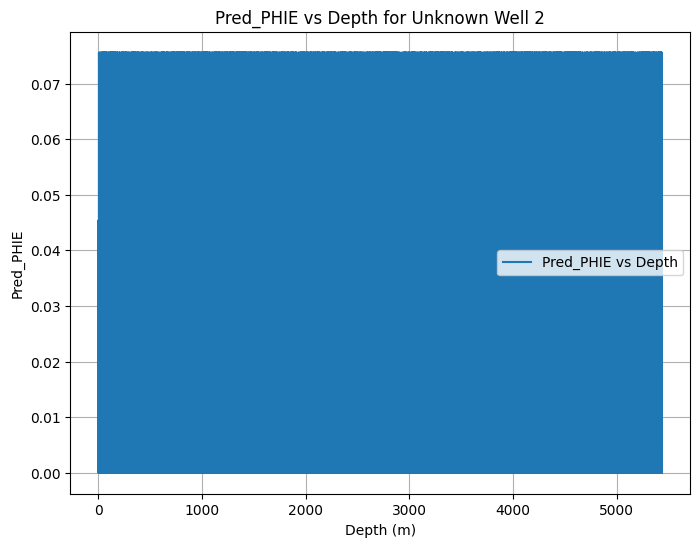

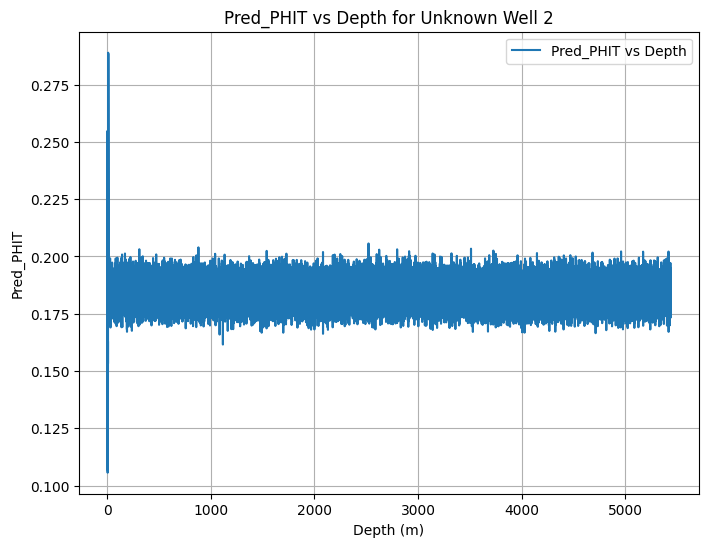

In [16]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Define the depth range, steps, and locations for the unknown wells
unknown_wells = {
    "Unknown Well 1": {"total_depth": 2034, "depth_step": 0.1, "location": (683447.00, 5072765.00)},
    "Unknown Well 2": {"total_depth": 5437, "depth_step": 0.1, "location": (691636.00, 5072723.00)}
}

# Load seismic dataset
seismic_dataset = pd.read_csv("seismic_dataset_real_values.csv")

# Initialize a dictionary to hold synthetic data
synthetic_data = {}

# Generate synthetic data for each unknown well
for well_name, well_info in unknown_wells.items():
    total_depth = well_info["total_depth"]
    depth_step = well_info["depth_step"]
    surface_x, surface_y = well_info["location"]
    depths = np.arange(0, total_depth + depth_step, depth_step)
    synthetic_df = pd.DataFrame({'DEPT': depths})

    print(f"\nGenerating synthetic data for {well_name} with depth range 0 to {total_depth} at {depth_step} intervals...")

    # Generate synthetic feature values based on known statistics
    for feature in ['RHOB', 'VSHALE', 'NPHI', 'RDEEP']:
        synthetic_df[feature] = np.random.normal(
            loc=filtered_df[feature].mean(),
            scale=filtered_df[feature].std(),
            size=len(depths)
        )

    # Incorporate seismic attributes
    well_seismic_data = seismic_dataset[seismic_dataset['Well Name'] == well_name]
    synthetic_df = synthetic_df.merge(well_seismic_data, on='DEPT', how='left').fillna(0)

    # Add derived features matching the training feature set
    synthetic_df['NPHI_RHOB_Ratio'] = synthetic_df['NPHI'] / synthetic_df['RHOB']
    synthetic_df['PHIE_PHIT_Diff'] = synthetic_df['NPHI'] - synthetic_df['VSHALE']
    synthetic_df['Gradient_DEPT_Product'] = synthetic_df['DEPT'] * synthetic_df['DEPT'].max()
    synthetic_df['Temperature_Ratio'] = synthetic_df['DEPT'] / total_depth
    synthetic_df['Depth_Normalized'] = synthetic_df['DEPT'] / total_depth

    # Simulate temperature increase starting at 25°C
    temp_start = 25
    temp_end = 100 if well_name == "Unknown Well 1" else 250
    synthetic_df['Pred_TEMP_GRADIENT_Smoothed'] = temp_start + (synthetic_df['DEPT'] / total_depth) * (temp_end - temp_start)

    # Introduce physical and geological variability
    synthetic_df['RHOB'] += np.random.normal(0, 0.05, len(depths))
    synthetic_df['VSHALE'] += np.random.normal(0, 0.02, len(depths))
    synthetic_df['NPHI'] += np.random.normal(0, 0.01, len(depths))
    synthetic_df['RDEEP'] += np.random.normal(0, 0.1, len(depths))

    # Ensure synthetic_df contains all features needed for prediction
    required_features = set(top_features_perm + top_features_temp_gradient + top_features_phie + top_features_phit)
    for feature in required_features:
        if feature not in synthetic_df.columns:
            synthetic_df[feature] = 0  # Add missing features with default values

    # Handle NaN or infinite values
    synthetic_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    synthetic_df.fillna(0, inplace=True)

    # Normalize synthetic data using training scalers
    scaler = MinMaxScaler()
    scaler.fit(filtered_df[list(required_features)])  # Fit scaler on training data features
    synthetic_df[list(required_features)] = scaler.transform(synthetic_df[list(required_features)])

    synthetic_data[well_name] = synthetic_df

# Predict properties for synthetic data
predictions = {}

for well_name, synthetic_df in synthetic_data.items():
    # Preserve DEPT column
    dept_column = synthetic_df['DEPT'].copy()

    # Select relevant columns for prediction
    X_synthetic_perm = synthetic_df[top_features_perm]  # Use only features from training
    X_synthetic_temp_gradient = synthetic_df[top_features_temp_gradient]
    X_synthetic_phie = synthetic_df[top_features_phie]
    X_synthetic_phit = synthetic_df[top_features_phit]

    print(f"\nMaking predictions for {well_name}...")

    # Apply model pipelines to predict properties
    synthetic_df['Pred_PERM'] = np.maximum(best_gb_perm.predict(X_synthetic_perm), 0)
    synthetic_df['Pred_PHIE'] = np.maximum(best_gb_phie.predict(X_synthetic_phie), 0)
    synthetic_df['Pred_PHIT'] = np.maximum(best_rf_phit.predict(X_synthetic_phit), 0)

    # Add variability to PHIT to ensure it changes with depth
    synthetic_df['Pred_PHIT'] += np.random.normal(0, 0.005, len(synthetic_df))

    # Restore DEPT column
    synthetic_df['DEPT'] = dept_column

    # Save predictions
    predictions[well_name] = synthetic_df[['DEPT', 'Pred_PERM', 'Pred_TEMP_GRADIENT_Smoothed', 'Pred_PHIE', 'Pred_PHIT']]

# Save predictions to CSV and summarize results
for well_name, prediction_df in predictions.items():
    csv_name = f"{well_name}_final_predictions.csv"
    prediction_df.to_csv(csv_name, index=False)
    print(f"Predictions for {well_name} saved to {csv_name}")

    # Print mean predicted values
    mean_predictions = prediction_df[['Pred_PERM', 'Pred_TEMP_GRADIENT_Smoothed', 'Pred_PHIE', 'Pred_PHIT']].mean()
    print(f"\nMean enhanced predicted properties for {well_name}:")
    print(mean_predictions)

# Plot the predicted properties versus depth
for well_name, prediction_df in predictions.items():
    for prop in ['Pred_TEMP_GRADIENT_Smoothed', 'Pred_PERM', 'Pred_PHIE', 'Pred_PHIT']:
        plt.figure(figsize=(8, 6))
        plt.plot(prediction_df['DEPT'], prediction_df[prop], label=f"{prop} vs Depth")
        plt.xlabel("Depth (m)")
        plt.ylabel(prop)
        plt.title(f"{prop} vs Depth for {well_name}")
        plt.legend()
        plt.grid(True)
        plt.show()
